In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras import layers, models


import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 


In [5]:
class CFG:
    seed = 42
    debug = False
    print_freq = 100
    num_workers = 1

    # Set your project root directory
    PROJECT_ROOT_DIR = ".." # Adjust as needed
    
    OUTPUT_DIR = "../data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR + "/spectograms/"
    
    train_datadir = '../data/raw/train_audio'
    train_csv = '../data/raw/train.csv'
    taxonomy_csv = '../data/raw/taxonomy.csv'
    working_df_path = "../data/work_df_w_split_info.csv"

    working_df = SPECTROGRAMS_DIR + 'working_df.csv'


    # Parametric input dim (32, 64, or 256)
    # This would be used to also control the input path and shape (see below)
    input_dim = 32 # Default to 32
    
    # Derived paths and shapes
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR + f'birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy'
    
    @property  # Add this to make it dynamic
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)
    
    in_channels = 1  # Single channel
    LOAD_DATA = True # Load data from precomputed spectrograms
    num_classes = 4  # 4 high-level classes

    epochs = 10
    batch_size = 128
    
    n_fold = 4
    selected_folds = [0,1,2,3]  # Use all folds by default

    lr = 5e-4 
    weight_decay = 1e-5
    min_lr = 1e-6
    

    # turning both on
    use_augmentation = False  # Toggle augmentation on/off
    use_oversampling = False  # Toggle oversampling on/off
    
    # Augmentation params
    aug_prob = 0.5 if use_augmentation else 0.0  # Probability of applying any augmentation
    mixup_alpha = 0.2 if use_augmentation else 0.0  # MixUp alpha (beta distribution)
    noise_std = 0.05  # Std dev for Gaussian noise
    max_time_shift = 0.2  # Fraction of time axis to shift (e.g., 20%)
    max_freq_shift = 0.2  # Fraction of freq axis to shift
    max_mask_time = 0.1  # Fraction of time axis to mask
    max_mask_freq = 0.1  # Fraction of freq axis to mask

    # Oversampling params: dict of {class_index: factor} to multiply minority samples
    # e.g., Aim to balance towards Aves (~5530 samples); set factor=0 for majority
    oversampling_factors = {0: 40,  # Amphibia (117 -> ~4680)
                            1: 0,   # Aves (majority, no oversampling)    
                            2: 150, # Insecta (31 -> ~4650)
                            3: 150, # Mammalia (35 -> ~5250)
                            }   
    
    # Derived model save name
    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:
            suffix += "_aug"
        if self.use_oversampling:
            suffix += "_os"
        return f"base_model_{str(self.input_dim)}{suffix}.keras"

    def update_debug_settings(self):
        # Only run 1 fold and 6 epochs in debug mode, we will use this as a quick test
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

cfg = CFG()

In [3]:
labels = pd.read_csv("../data/work_df_w_split_info.csv")

In [6]:
# load dict with allow_pickle=True
cfg.input_dim = 64
spectrograms_dict = np.load(cfg.spectrogram_npy, allow_pickle=True).item()

# confirm a key
print(list(spectrograms_dict.keys())[0])
print(spectrograms_dict["1139490-CSA36385"].shape)


1139490-CSA36385
(64, 64)


In [34]:
def build_spectograms(spec_dict):
    """building list of spectograms with matching labels in order
    spec_dict: dictionary imported from .npy file
    returns X"""
    X_list = []
    for sample_name in labels["samplename"]:
        spec = spec_dict.get(sample_name)
        if spec is None:
            raise ValueError(f"Missing spectogram for sample: {sample_name}")
        # flatten
        if spec_dict["1139490-CSA36385"].shape[0] == 256:
            # reduce to np.float16 if data is 256*256 to prevent kernel dying..
            X_list.append(spec.flatten().astype(np.float16))
        else:
            X_list.append(spec.flatten())
    
    X = np.vstack(X_list)

    return X


In [7]:
# build list of spectrograms matching labels['samplename'] order
X_list = []
for sample_name in labels['samplename']:
    spec = spectrograms_dict.get(sample_name)
    if spec is None:
        raise ValueError(f"Missing spectrogram for sample: {sample_name}")
    # changing to np.float16 due to kernel dying!!!
    X_list.append(spec.flatten())  # flatten 2D to 1D vector

# Convert list to numpy array
X = np.vstack(X_list)   # shape should be (num_samples, 256*256)
print(X.shape)

(28564, 4096)


In [37]:
def train_val_test_split(X, labels):
    """takes in df with species encoded, X to use in splitting
    returns train, val, test X and ys"""

    # taking in the labels and turning them into masks
    train_mask = labels["split"] == "train"
    val_mask = labels["split"] == "val"
    test_mask = labels["split"] == "test"

    X_train = X[train_mask]
    y_train = labels.loc[train_mask, 'y_species_encoded'].values

    X_val = X[val_mask]
    y_val = labels.loc[val_mask, 'y_species_encoded'].values

    X_test = X[test_mask]
    y_test = labels.loc[test_mask, 'y_species_encoded'].values


    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# train test splitting mask according to labels["split"]
train_mask = labels['split'] == 'train'
val_mask = labels['split'] == 'val'
test_mask = labels['split'] == 'test'

In [9]:
X_train = X[train_mask]
y_train = labels.loc[train_mask, 'y_species_encoded'].values

In [10]:
X_val = X[val_mask]
y_val = labels.loc[val_mask, 'y_species_encoded'].values


In [11]:
X_test = X[test_mask]
y_test = labels.loc[test_mask, 'y_species_encoded'].values

In [11]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print("")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (17138, 65536)
y_train shape: (17138,)

X_val shape: (5713, 65536)
y_val shape: (5713,)

X_test shape: (5713, 65536)
y_test shape: (5713,)


In [12]:
# confirm that it's encoded
print(f"y values ranges from {y_val.min()} to {y_val.max()}")

y values ranges from 0 to 3


In [13]:
mid = X_train.shape[0] // 2
X_train_1 = X_train[:mid, :]
X_train_2 = X_train[mid:, :]

print(f"X_train_1: {X_train_1.shape}, X_train_2: {X_train_2.shape}")

X_train_1: (8569, 65536), X_train_2: (8569, 65536)


In [14]:
y_train_1 = y_train[:mid]
y_train_2 = y_train[mid:]

print(f"y_train_1: {y_train_1.shape}, y_train_2: {y_train_2.shape}")

y_train_1: (8569,), y_train_2: (8569,)


In [ ]:
# shuffle X_train to split
N = X_train.shape[0]
indices = np.arange(N)

shuffled_indices = np.random.permutation(indices)
shuffled_X = X_train[shuffled_indices]
shuffled_y = y_train[shuffled_indices]

X_train_shuff1 = shuffled_X[:mid, :]
X_train_shuff2 = shuffled_X[mid:, :]

y_train_shuff1 = shuffled_y[:mid]
y_train_shuff2 = shuffled_y[mid:]

print(f"X_train1 shuffled shape: {X_train_shuff1.shape},\n y_train1 shuffled shape: {y_train_shuff1.shape}")


X_train1 shuffled shape: (8569, 65536),
 y_train1 shuffled shape: (8569,)


In [13]:
# get shape
input_shape = X_train.shape[1]
input_shape

4096

In [42]:

def build_flatnn(n_classes = 4, 
                 X = X,
                 metrics = "accuracy",
                 hidden_layer_sizes = [],
                 learning_rate = 1e-04):
    """takes in 
    number of classes: 4 as default
    input shape: flattened X
    metrics: measure of model performance"""

    # building model
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    input_shape = X.shape[1]

    model = models.Sequential()

    model.add(layers.Input(shape = (input_shape, )))

    for units in hidden_layer_sizes:
        model.add(layers.Dense(units, activation = "relu"))
        model.add(layers.Dropout(.3))

    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(n_classes, activation = "softmax"))

    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = opt,
                  loss = "sparse_categorical_crossentropy",
                  metrics = [metrics])

    return model
 

In [41]:
def train_and_evaluate(n_classes = 4, 
                       X = X,
                       metrics = 'accuracy',
                       hidden_layer_sizes = [],
                       learning_rate = 1e-04,
                       n_epochs = 20):
    
    # Build the model
    model = build_flatnn(n_classes = n_classes,
                          metrics= metrics,
                          X = X,
                          hidden_layer_sizes=hidden_layer_sizes,
                          learning_rate = learning_rate)

  
  # Train the model.
    print(f"Training model...")
    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data = (X_val, y_val),
        epochs= n_epochs,
        batch_size = 64)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(n_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model

In [16]:
# let's build it first
model_basic = build_flatnn()

## 64-64 dataset

In [17]:
history_basic_64 = model_basic.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val, y_val),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9484 - loss: 0.2488 - val_accuracy: 0.9680 - val_loss: 0.1968
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1725 - val_accuracy: 0.9680 - val_loss: 0.1936
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9713 - loss: 0.1674 - val_accuracy: 0.9680 - val_loss: 0.1909
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1639 - val_accuracy: 0.9680 - val_loss: 0.1907
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9713 - loss: 0.1614 - val_accuracy: 0.9680 - val_loss: 0.1871
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1590 - val_accuracy: 0.9681 - val_loss: 0.1887
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1565 - val_accuracy: 0.9680 - val_loss: 0.1880
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1545 - val_accu

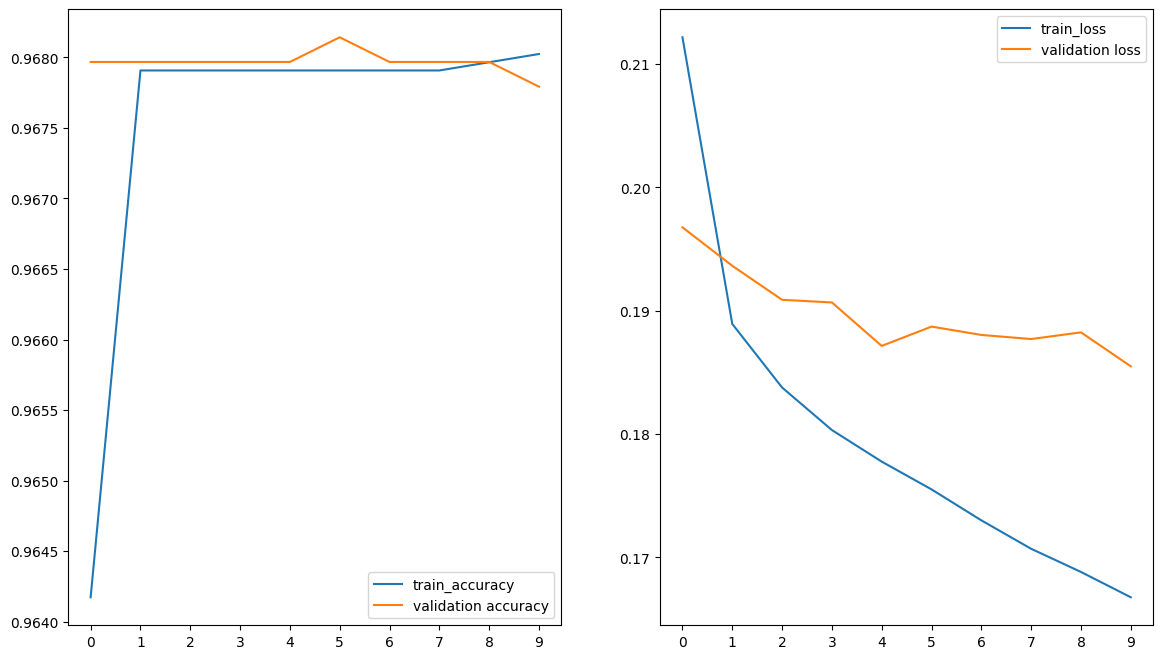

Training accuracy: 0.9680
Validation accuracy:  0.9678


In [21]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

ax[0].plot(history_basic_64.history["accuracy"], label='train_accuracy')
ax[0].plot(history_basic_64.history["val_accuracy"], label='validation accuracy')
ax[0].set_xticks(range(10))
ax[0].legend()

ax[1].plot(history_basic_64.history["loss"], label='train_loss')
ax[1].plot(history_basic_64.history["val_loss"], label='validation loss')
ax[1].set_xticks(range(10))
ax[1].legend()

plt.show()
    
print(f'Training accuracy: {history_basic_64.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy:  {history_basic_64.history["val_accuracy"][-1]:.4f}')

### with augmentation

In [22]:
cfg.use_augmentation = True
spectrograms_dict_aug = np.load(cfg.spectrogram_npy, allow_pickle=True).item()

# confirm a key
print(list(spectrograms_dict_aug.keys())[0])
print(spectrograms_dict_aug["1139490-CSA36385"].shape)


1139490-CSA36385
(64, 64)


In [35]:
X_64_aug = build_spectograms(spectrograms_dict_aug)
X_64_aug.shape

(28564, 4096)

In [38]:
# splitting
X_64_aug_train, y_64_aug_train, X_64_aug_val, y_64_aug_val, X_64_aug_test, y_64_aug_test = train_val_test_split(X_64_aug, labels)

In [39]:
print(f"X_train shape: {X_64_aug_train.shape}")
print(f"y_train shape: {y_64_aug_train.shape}")

X_train shape: (17138, 4096)
y_train shape: (17138,)


In [43]:
model_64_aug = build_flatnn(X = X_64_aug_train)

In [44]:
history_64_aug = model_64_aug.fit(
    x = X_64_aug_train,
    y = y_64_aug_train,
    validation_data = (X_64_aug_val, y_64_aug_val),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9491 - loss: 0.2344 - val_accuracy: 0.9680 - val_loss: 0.1965
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9713 - loss: 0.1720 - val_accuracy: 0.9680 - val_loss: 0.1910
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9713 - loss: 0.1670 - val_accuracy: 0.9680 - val_loss: 0.1896
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9713 - loss: 0.1635 - val_accuracy: 0.9681 - val_loss: 0.1859
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9713 - loss: 0.1605 - val_accuracy: 0.9680 - val_loss: 0.1849
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9713 - loss: 0.1579 - val_accuracy: 0.9681 - val_loss: 0.1873
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9713 - loss: 0.1559 - val_accuracy: 0.9681 - val_loss: 0.1849
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9713 - loss: 0.1533 - val_accu

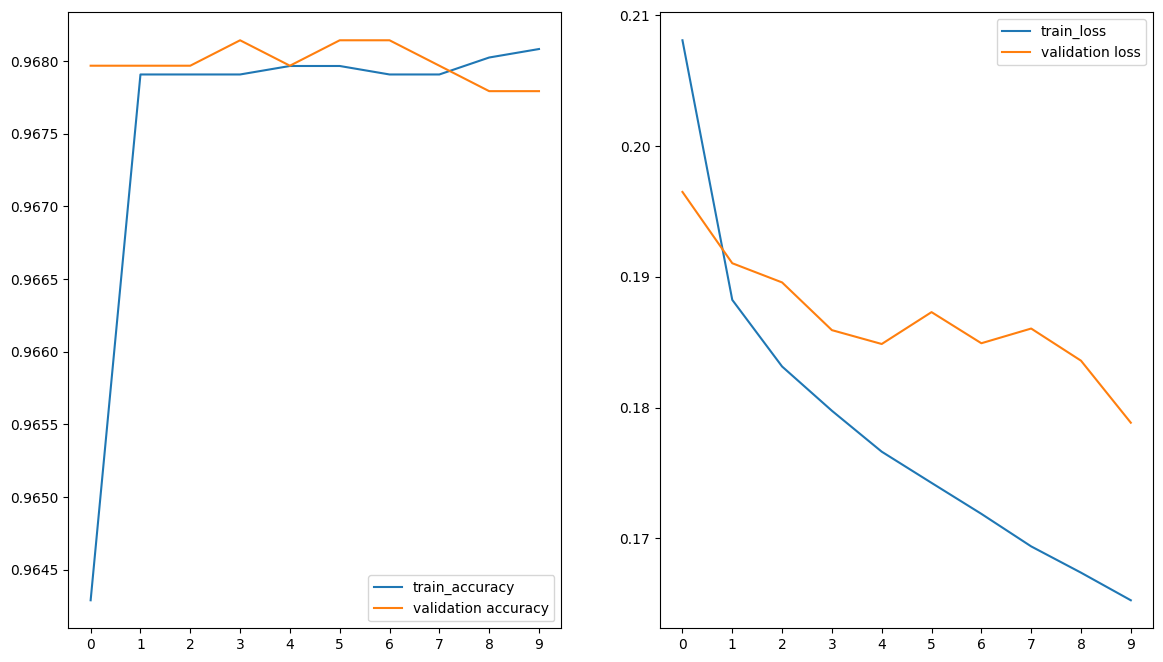

Training accuracy: 0.9681
Validation accuracy:  0.9678


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

ax[0].plot(history_64_aug.history["accuracy"], label='train_accuracy')
ax[0].plot(history_64_aug.history["val_accuracy"], label='validation accuracy')
ax[0].set_xticks(range(10))
ax[0].legend()

ax[1].plot(history_64_aug.history["loss"], label='train_loss')
ax[1].plot(history_64_aug.history["val_loss"], label='validation loss')
ax[1].set_xticks(range(10))
ax[1].legend()

plt.show()
    
print(f'Training accuracy: {history_64_aug.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy:  {history_64_aug.history["val_accuracy"][-1]:.4f}')

### With oversampling

In [46]:
cfg.use_augmentation = False
cfg.use_oversampling = True
spectrograms_dict_os = np.load(cfg.spectrogram_npy, allow_pickle=True).item()

# confirm a key
print(list(spectrograms_dict_os.keys())[0])
print(spectrograms_dict_os["1139490-CSA36385"].shape)

1139490-CSA36385
(64, 64)


In [48]:
X_64_os = build_spectograms(spectrograms_dict_os)
X_64_os.shape

(28564, 4096)

In [49]:
X_64_os_train, y_64_os_train, X_64_os_val, y_64_os_val, X_64_os_test, y_64_os_test = train_val_test_split(X_64_os, labels)

In [50]:
print(f"X_train shape: {X_64_os_train.shape}")
print(f"y_train shape: {y_64_os_train.shape}")

X_train shape: (17138, 4096)
y_train shape: (17138,)


In [52]:
model_64_os = build_flatnn(X = X_64_os_train)

In [53]:
history_64_os = model_64_os.fit(
    x = X_64_os_train,
    y = y_64_os_train,
    validation_data = (X_64_os_val, y_64_os_val),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9501 - loss: 0.2288 - val_accuracy: 0.9680 - val_loss: 0.1974
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9713 - loss: 0.1723 - val_accuracy: 0.9680 - val_loss: 0.1924
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9713 - loss: 0.1676 - val_accuracy: 0.9680 - val_loss: 0.1895
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1632 - val_accuracy: 0.9680 - val_loss: 0.1880
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9713 - loss: 0.1605 - val_accuracy: 0.9680 - val_loss: 0.1874
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9713 - loss: 0.1577 - val_accuracy: 0.9681 - val_loss: 0.1865
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9713 - loss: 0.1554 - val_accuracy: 0.9680 - val_loss: 0.1868
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9713 - loss: 0.1534 - val_accu

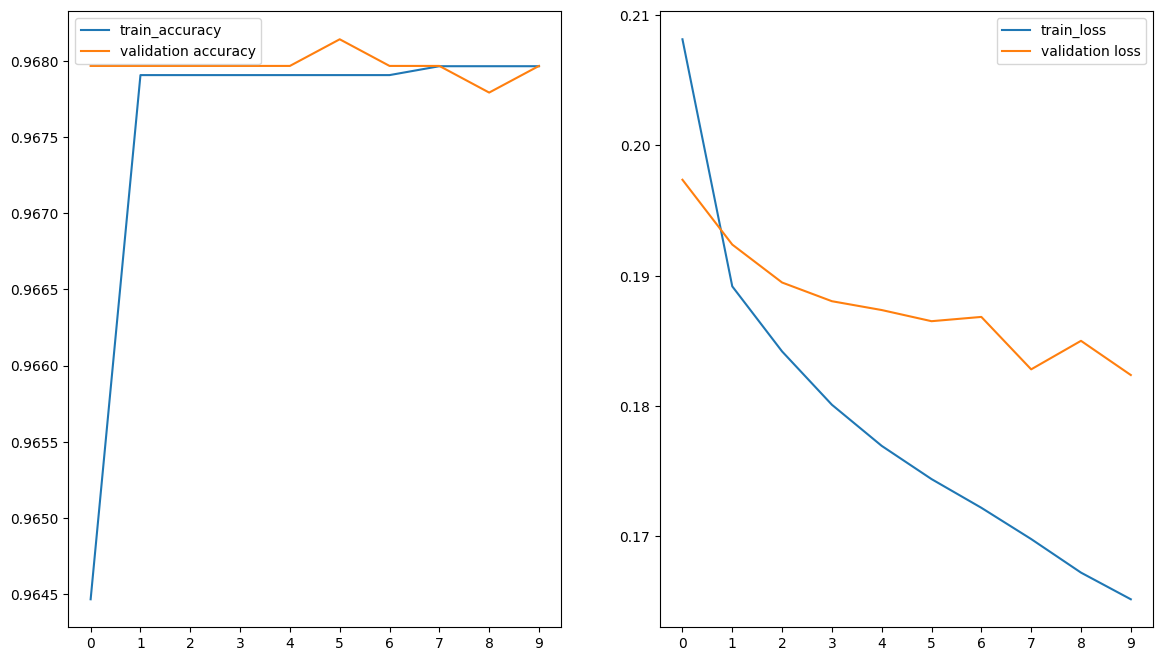

Training accuracy: 0.9680
Validation accuracy:  0.9680


In [55]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

ax[0].plot(history_64_os.history["accuracy"], label='train_accuracy')
ax[0].plot(history_64_os.history["val_accuracy"], label='validation accuracy')
ax[0].set_xticks(range(10))
ax[0].legend()

ax[1].plot(history_64_os.history["loss"], label='train_loss')
ax[1].plot(history_64_os.history["val_loss"], label='validation loss')
ax[1].set_xticks(range(10))
ax[1].legend()

plt.show()
    
print(f'Training accuracy: {history_64_os.history["accuracy"][-1]:.4f}')
print(f'Validation accuracy:  {history_64_os.history["val_accuracy"][-1]:.4f}')

## 256-256 dataset

In [17]:
# train
history_basic_1 = model_basic.fit(
    x = X_train_1,
    y = y_train_1,
    validation_data = (X_val, y_val),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.9121 - loss: 1.0448 - val_accuracy: 0.9669 - val_loss: 0.1970
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9195 - loss: 0.4642 - val_accuracy: 0.9646 - val_loss: 0.2576
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9275 - loss: 0.3920 - val_accuracy: 0.9669 - val_loss: 0.1938
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9307 - loss: 0.3673 - val_accuracy: 0.9666 - val_loss: 0.1913
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9321 - loss: 0.3504 - val_accuracy: 0.9669 - val_loss: 0.1903
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9315 - loss: 0.3516 - val_accuracy: 0.9657 - val_loss: 0.2146
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9313 - loss: 0.3385 - val_accuracy: 0.9676 - val_loss: 0.1861
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.9317 - loss: 0

The model starts overfitting

In [18]:
history_basic_2 = model_basic.fit(
    x = X_train_2,
    y = y_train_2,
    validation_data = (X_val, y_val),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9997 - loss: 0.0080 - val_accuracy: 0.9680 - val_loss: 0.5198
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9680 - val_loss: 0.7971
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 1.0000 - loss: 6.0925e-04 - val_accuracy: 0.9680 - val_loss: 1.1495
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 3.4900e-04 - val_accuracy: 0.9680 - val_loss: 1.3898
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 1.0000 - loss: 2.3980e-04 - val_accuracy: 0.9680 - val_loss: 1.5726
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 1.0000 - loss: 1.7804e-04 - val_accuracy: 0.9680 - val_loss: 1.7224
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 1.3804e-04 - val_accuracy: 0.9680 - val_loss: 1.8504
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accura

In [36]:
epoch = [i for i in range(20)]
loss = history_basic_1.history["loss"] + history_basic_2.history["loss"]
val_loss = history_basic_1.history["val_loss"] + history_basic_2.history["val_loss"]

acc = history_basic_1.history["accuracy"] + history_basic_2.history["accuracy"]
val_acc = history_basic_1.history["val_accuracy"] + history_basic_2.history["val_accuracy"]

history_basic = pd.DataFrame({
    "epoch": epoch,
    "loss": loss,
    "val_loss": val_loss,
    "accuracy": acc,
    "val_accuracy": val_acc
})

display(history_basic)

,epoch,loss,val_loss,accuracy,val_accuracy
0,0,0.615608,0.197039,0.927880,0.966918
1,1,0.424068,0.257621,0.927880,0.964642
2,2,0.384803,0.193800,0.929630,0.966918
3,3,0.344517,0.191327,0.933948,0.966567
4,4,0.332172,0.190349,0.934882,0.966918
5,5,0.330098,0.214602,0.934648,0.965692
6,6,0.329660,0.186125,0.933948,0.967618
7,7,0.313115,0.192682,0.935348,0.967093
8,8,0.327619,0.187724,0.933364,0.966567
9,9,0.314502,0.227494,0.936399,0.967093


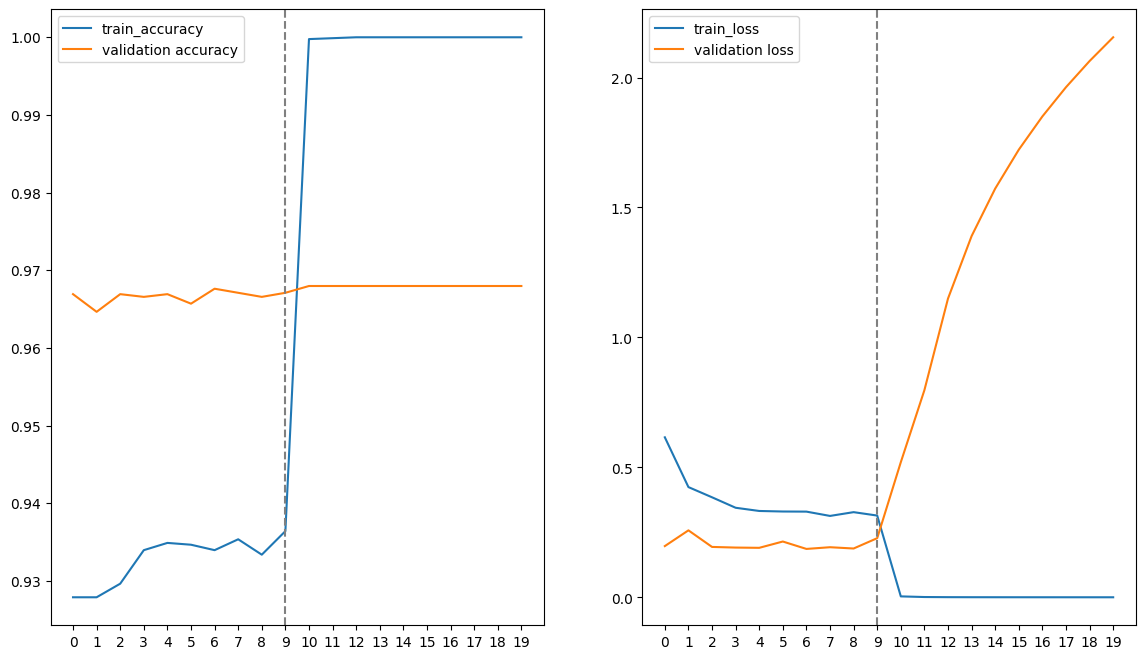

Training accuracy: 1.0000
Validation accuracy:  0.9680


In [51]:


fig, ax = plt.subplots(1, 2, figsize = (14, 8))

ax[0].plot(history_basic["accuracy"], label='train_accuracy')
ax[0].plot(history_basic["val_accuracy"], label='validation accuracy')
ax[0].set_xticks(range(20))
ax[0].axvline(x = 9, linestyle = "--", color = "grey")
ax[0].legend()

ax[1].plot(history_basic["loss"], label='train_loss')
ax[1].plot(history_basic["val_loss"], label='validation loss')
ax[1].set_xticks(range(20))
ax[1].axvline(x = 9, linestyle = "--", color = "grey")
ax[1].legend()

plt.show()
    
print(f'Training accuracy: {history_basic["accuracy"].iloc[-1]:.4f}')
print(f'Validation accuracy:  {history_basic["val_accuracy"].iloc[-1]:.4f}')

In [19]:
test_loss, test_acc = model_basic.evaluate(X_test, y_test)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8614 - loss: 8.4052
test loss: 1.95, test accuracy: 0.97


In [20]:
model_basic_shuffled =  build_flatnn()

In [21]:
# train 1
history_basic_shuffled1 = model_basic_shuffled.fit(
    x = X_train_shuff1,
    y = y_train_shuff1,
    validation_data = (X_val, y_val),
    epochs = 5,
    batch_size = 64
)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.9509 - loss: 0.8259 - val_accuracy: 0.9680 - val_loss: 0.2134
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9650 - loss: 0.2293 - val_accuracy: 0.9681 - val_loss: 0.2066
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9650 - loss: 0.2269 - val_accuracy: 0.9681 - val_loss: 0.2007
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.9650 - loss: 0.2233 - val_accuracy: 0.9681 - val_loss: 0.2063
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9650 - loss: 0.2221 - val_accuracy: 0.9680 - val_loss: 0.1959


In [22]:
# train 2
history_basic_shuffled2 = model_basic_shuffled.fit(
    x = X_train_shuff2,
    y = y_train_shuff2,
    validation_data = (X_val, y_val),
    epochs = 5,
    batch_size = 64
)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.9712 - loss: 0.1870 - val_accuracy: 0.9680 - val_loss: 0.2026
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.9712 - loss: 0.1725 - val_accuracy: 0.9681 - val_loss: 0.1913
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9714 - loss: 0.1683 - val_accuracy: 0.9680 - val_loss: 0.1920
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9716 - loss: 0.1661 - val_accuracy: 0.9681 - val_loss: 0.1842
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9716 - loss: 0.1649 - val_accuracy: 0.9680 - val_loss: 0.1832


In [23]:
epoch = [i for i in range(10)]
loss = history_basic_shuffled1.history["loss"] + history_basic_shuffled2.history["loss"]
val_loss = history_basic_shuffled1.history["val_loss"] + history_basic_shuffled2.history["val_loss"]

acc = history_basic_shuffled1.history["accuracy"] + history_basic_shuffled2.history["accuracy"]
val_acc = history_basic_shuffled1.history["val_accuracy"] + history_basic_shuffled2.history["val_accuracy"]

history_basic_shuffled = pd.DataFrame({
    "epoch": epoch,
    "loss": loss,
    "val_loss": val_loss,
    "accuracy": acc,
    "val_accuracy": val_acc
})

display(history_basic_shuffled)

,epoch,loss,val_loss,accuracy,val_accuracy
0,0,0.457657,0.213386,0.960322,0.967968
1,1,0.213754,0.206556,0.966507,0.968143
2,2,0.211274,0.200745,0.966507,0.968143
3,3,0.208438,0.206323,0.966507,0.968143
4,4,0.206441,0.195882,0.966507,0.967968
5,5,0.202124,0.202630,0.968724,0.967968
6,6,0.185205,0.191327,0.968841,0.968143
7,7,0.181871,0.192023,0.969075,0.967968
8,8,0.179820,0.184155,0.969191,0.968143
9,9,0.178127,0.183213,0.969191,0.967968


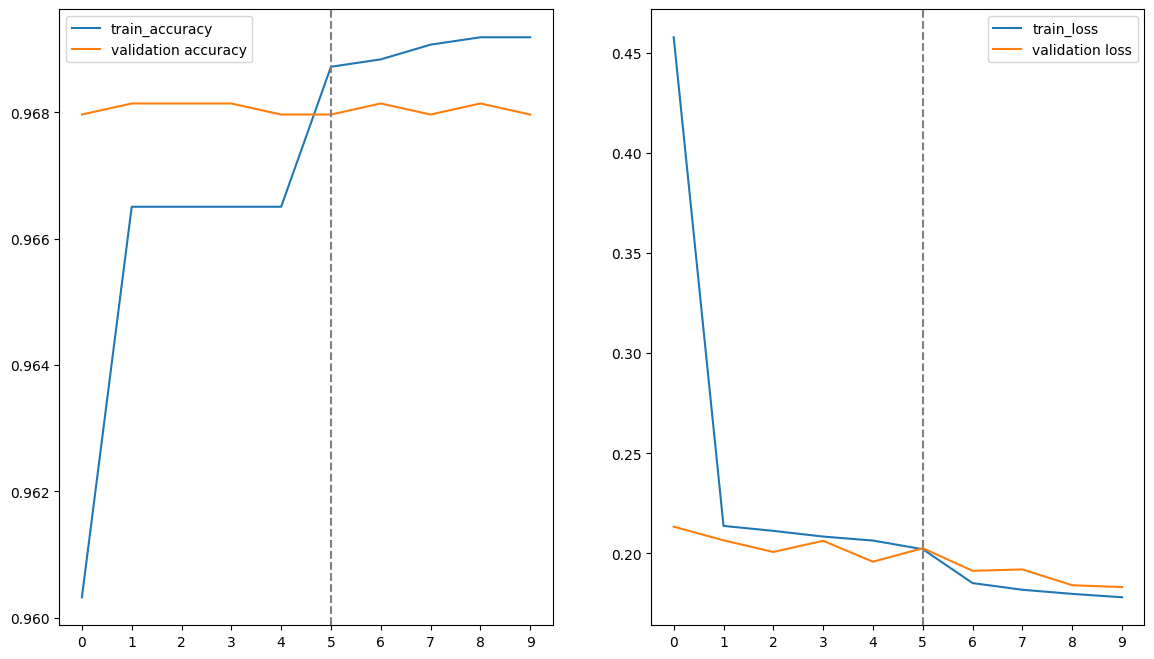

Training accuracy: 0.9692
Validation accuracy:  0.9680


In [26]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8))

ax[0].plot(history_basic_shuffled["accuracy"], label='train_accuracy')
ax[0].plot(history_basic_shuffled["val_accuracy"], label='validation accuracy')
ax[0].set_xticks(range(10))
ax[0].axvline(x = 5, linestyle = "--", color = "grey")
ax[0].legend()

ax[1].plot(history_basic_shuffled["loss"], label='train_loss')
ax[1].plot(history_basic_shuffled["val_loss"], label='validation loss')
ax[1].set_xticks(range(10))
ax[1].axvline(x = 5, linestyle = "--", color = "grey")
ax[1].legend()

plt.show()
    
print(f'Training accuracy: {history_basic_shuffled["accuracy"].iloc[-1]:.4f}')
print(f'Validation accuracy:  {history_basic_shuffled["val_accuracy"].iloc[-1]:.4f}')

In [ ]:
test_shuf_loss, test_shuf_acc = model_basic_shuffled.evaluate(X_test, y_test)
 
print(f"shuffled set test loss: {test_shuf_loss:.4f},\nshuffled set test accuracy: {test_shuf_acc:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8624 - loss: 0.5927
shuffled set test loss: 0.1702,
shuffled set test accuracy: 0.9681
